# 谐波均值滤波

In [1]:
#coding:utf-8
%matplotlib inline
import numpy as np
import scipy
from scipy.special import comb
import matplotlib.pyplot as plt
import cv2
from scipy import stats
import scipy.ndimage.filters as nd_filters
import time
from numpy.linalg import cholesky

In [2]:
gray = cv2.imread('../../datas/f4.jpg',0)
rgb = cv2.cvtColor(cv2.imread('../../datas/f4.jpg'),cv2.COLOR_BGR2RGB)
rows,cols,ch = rgb.shape

In [3]:
def noise_pepper(img,a):
    m,n = img.shape[0],img.shape[1]
    R = np.random.randn(m,n)
    dst = np.zeros(img.shape,dtype=np.float64)
    rgb = np.float64(img)
#     df_R = DataFrame(R)
    idx = R <= a
    dst[idx] = rgb[idx]
    return dst

In [4]:
def noise_gaussian(M,N,a = 0,b=1):
    R = a + b * np.random.randn(M,N)
    return R

In [5]:
src_noise_pepper = noise_pepper(gray,0.01)
noise = noise_gaussian(rows,cols,a=0,b=0.1)
src_noise_gray = gray.astype(np.float32) + noise * 255
src_noise_gray[src_noise_gray < 0] = 0
src_noise_gray[src_noise_gray > 255] = 255
src_noise_gray = src_noise_gray.astype(np.uint8)

In [6]:
def filter2d(input_img, filter):
    """Apply a 2-d filter to a 2-d image."""
    M, N = input_img.shape  # M is height, N is width
    n, m = len(filter), len(filter[0])  # m is height, n is width
    a, b = m // 2, n // 2  # size of neighborhood

    # get transpose of the 1-d filter
    if isinstance(filter, np.ndarray):
        wt = filter.ravel()
    else:
        wt = np.array(filter).ravel()

    def correlate(x, y):
        # z = np.zeros(n * m)  # pad with zeros
        z = np.full(n * m, input_img[x, y])  # pad with border duplicates
        # fill in available neighborhood
        for i in range(x - a, x + a + 1):
            for j in range(y - b, y + b + 1):
                if i >= 0 and i < M and j >= 0 and j < N:
                    z[(i - x + a) * n + j - y + b] = input_img[i, j]
        return np.dot(wt, z)

    # apply to each pixel
    xx, yy = np.meshgrid(np.arange(M), np.arange(N), indexing='ij')
    vf = np.vectorize(correlate)
    return vf(xx, yy)

In [7]:
def arithmetic_mean(img, size):
    """Smooth the given image with arithmetic mean filter of given size."""
    m, n = size
    kernel = np.full((m, n), float(1) / (m * n))  # denominator
    return filter2d(img, kernel)

In [8]:
def harmonymean_filter(x,n):
    eps = 1.0e-5
    x_f = x.astype(np.float32)/255
    dst = n * n / cv2.filter2D(1.0 /(x_f + eps),-1,np.ones((n,n)) / (n * n))
#     print(dst)
    #dst = (x_f - dst) * 255
#     dst = dst * 255
#     dst[dst < 0] = 0
#     dst[dst > 255] = 255
#     dst = dst.astype(np.uint8)
    return dst
#     x_f = x.astype(np.float32)+eps
#     inverse = np.reciprocal(x_f)
#     result = np.reciprocal(arithmetic_mean(inverse,(3,3)))
# #     print(result)
#     result = result.astype(np.uint8)
#     return result

In [9]:
dst = harmonymean_filter(src_noise_pepper,3)

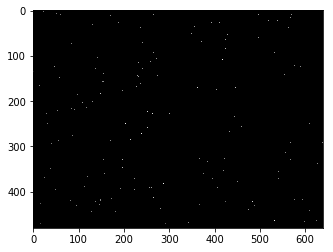

In [10]:
plt.imshow(dst,'gray')

In [11]:
import sys
def harmonicMeanFilter(im,n,m):
    [height,weight] = np.shape(im)
    newIm = np.zeros([height,weight])
    for i in range(height):
        for j in range(weight):
            count = 0
            sum = 0
            for k in range(n):
                for l in range(m):
                    posi, posj = i + k - n // 2, j + l - m // 2
                    if posi < 0 or posi >= height or \
                                    posj < 0 or posj >= weight:
                        continue
                    count += 1
                    #防止除零
                    sum += 1. / (im[posi,posj]+sys.float_info.epsilon)
            newIm[i,j] = count / sum
    newIm[newIm>255] =255
    newIm[newIm<0] = 0
    return newIm

In [12]:
dst_hm = harmonicMeanFilter(src_noise_pepper,3,3)

In [13]:
def counter_harmonic(src,ksize,Q):
    dst = np.zeros_like(src).astype(np.float32)
    src_f = src.astype(np.float32)
    val = 0.0
    rows,cols = src.shape[0],src.shape[1]
    center = ksize//2
    for i in range(center,rows - center):
        for j in range(center,cols - center):
            a = 0
            b = 0
            for k in range(-center,center + i):
                for w in range(-center,center+j):
                    val = src_f[k,w]
                    a += val ** (1.0 + Q)
                    b += val ** Q
            dst[i - center,j-center] = a / b
            
    return dst

In [ ]:
dst_ch = counter_harmonic(src_noise_gray,3,0.5)

In [ ]:
plt.imshow(dst_ch,'gray')